# Dark Souls II Reviews (2025)

In [1]:
from get_data import *

## Steam Reviews as of 3/26/25:

In [2]:
reviews = get_data()

## Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews

Splitting the reviews by how many do and don't recommend buying the game:

In [3]:
pos_reviews = reviews[reviews['voted_up'] == True]
neg_reviews = reviews[reviews['voted_up'] == False]

In [4]:
pos_reviews.shape, neg_reviews.shape

((37387, 10), (8176, 10))

### Top2Vec:

In [5]:
from top2vec import Top2Vec

In [6]:
docs = reviews['review'].tolist()
pos_docs = pos_reviews['review'].tolist()
neg_docs = neg_reviews['review'].tolist()

In [7]:
# mdl = topics(docs)

In [8]:
# pos_mdl = topics(pos_docs)

In [9]:
# pos_topic_words, pos_word_scores, pos_topic_nums = pos_mdl.get_topics(pos_mdl.get_num_topics())
# pos_topic_words, pos_word_scores, pos_topic_nums

In [10]:
neg_mdl = topics(neg_docs)

2025-04-04 07:49:19,293 - top2vec - INFO - Pre-processing documents for training
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-04-04 07:49:21,634 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-04-04 07:49:24,330 - top2vec - INFO - Creating joint document/word embedding
2025-04-04 07:54:06,912 - top2vec - INFO - Creating lower dimension embedding of documents
2025-04-04 07:55:09,630 - top2vec - INFO - Finding dense areas of documents
2025-04-04 07:55:10,366 - top2vec - INFO - Finding topics


In [11]:
neg_topic_words, neg_word_scores, neg_topic_nums = neg_mdl.get_topics(neg_mdl.get_num_topics())

In [12]:
neg_mdl.save("models/neg_topics_model")
neg_mdl = Top2Vec.load("models/neg_topics_model")

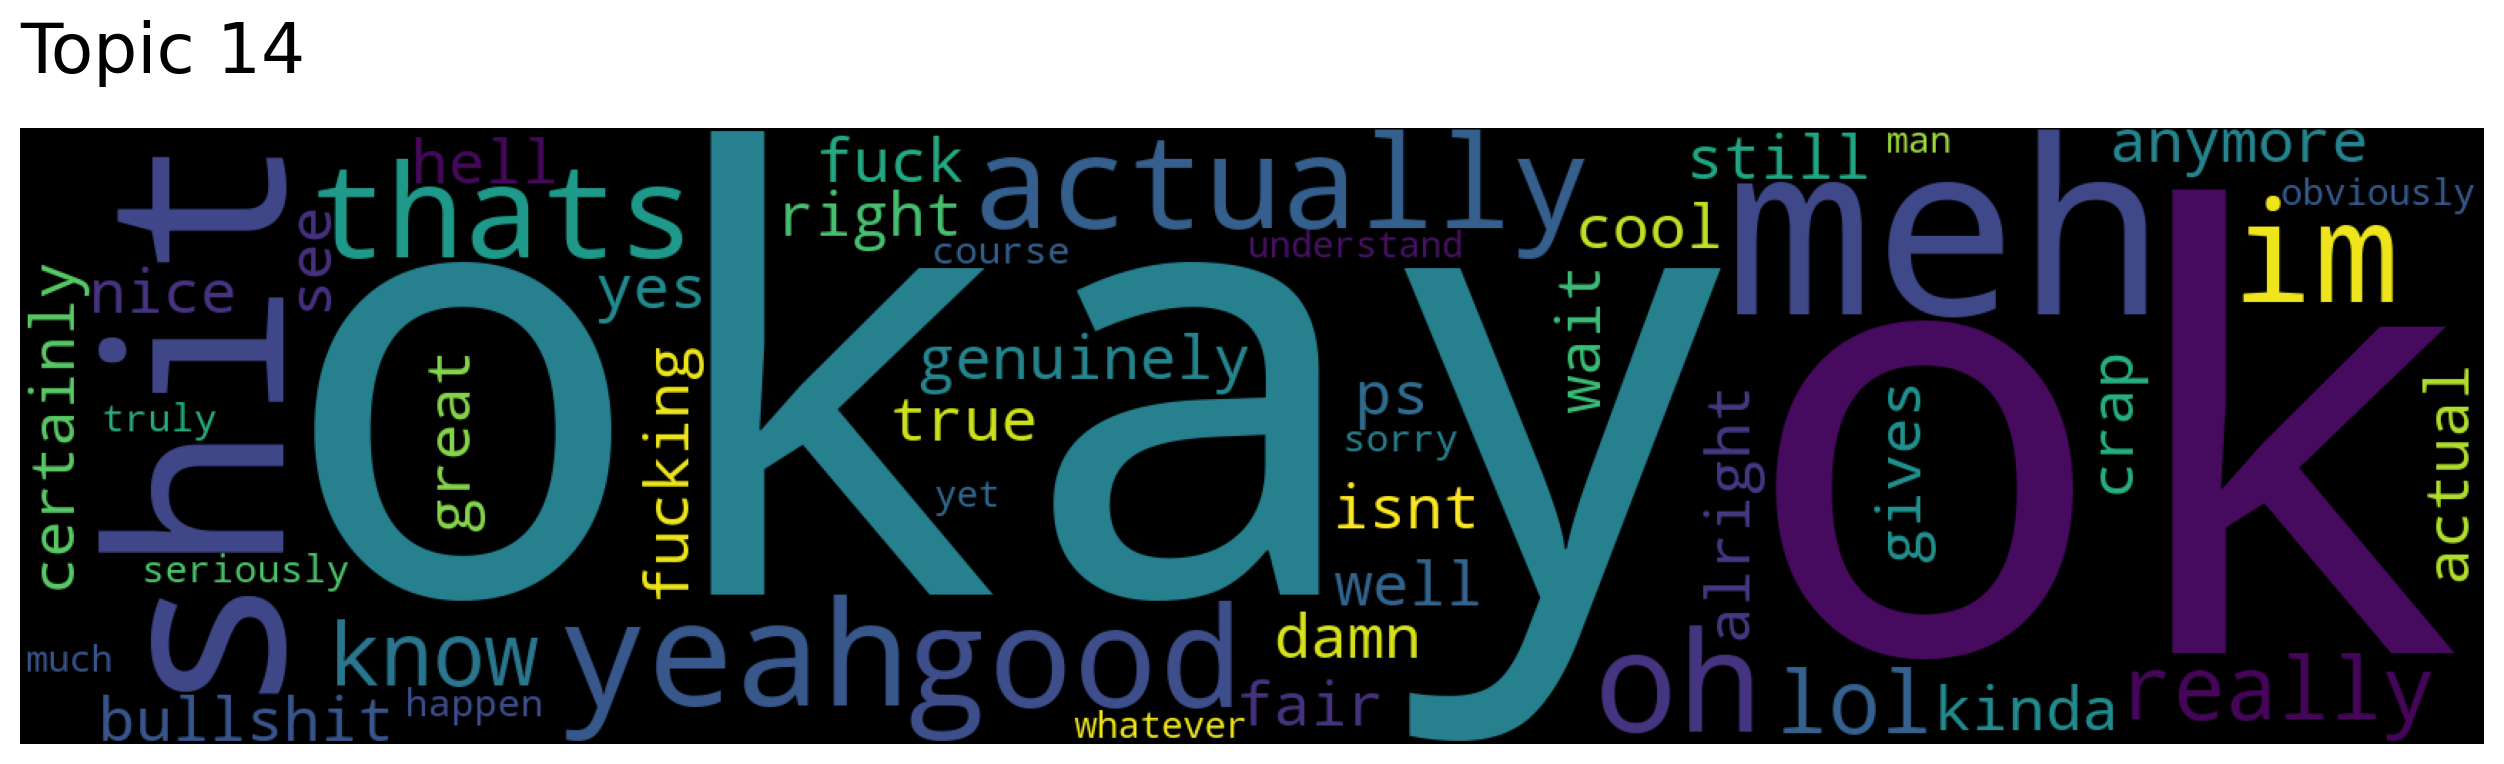

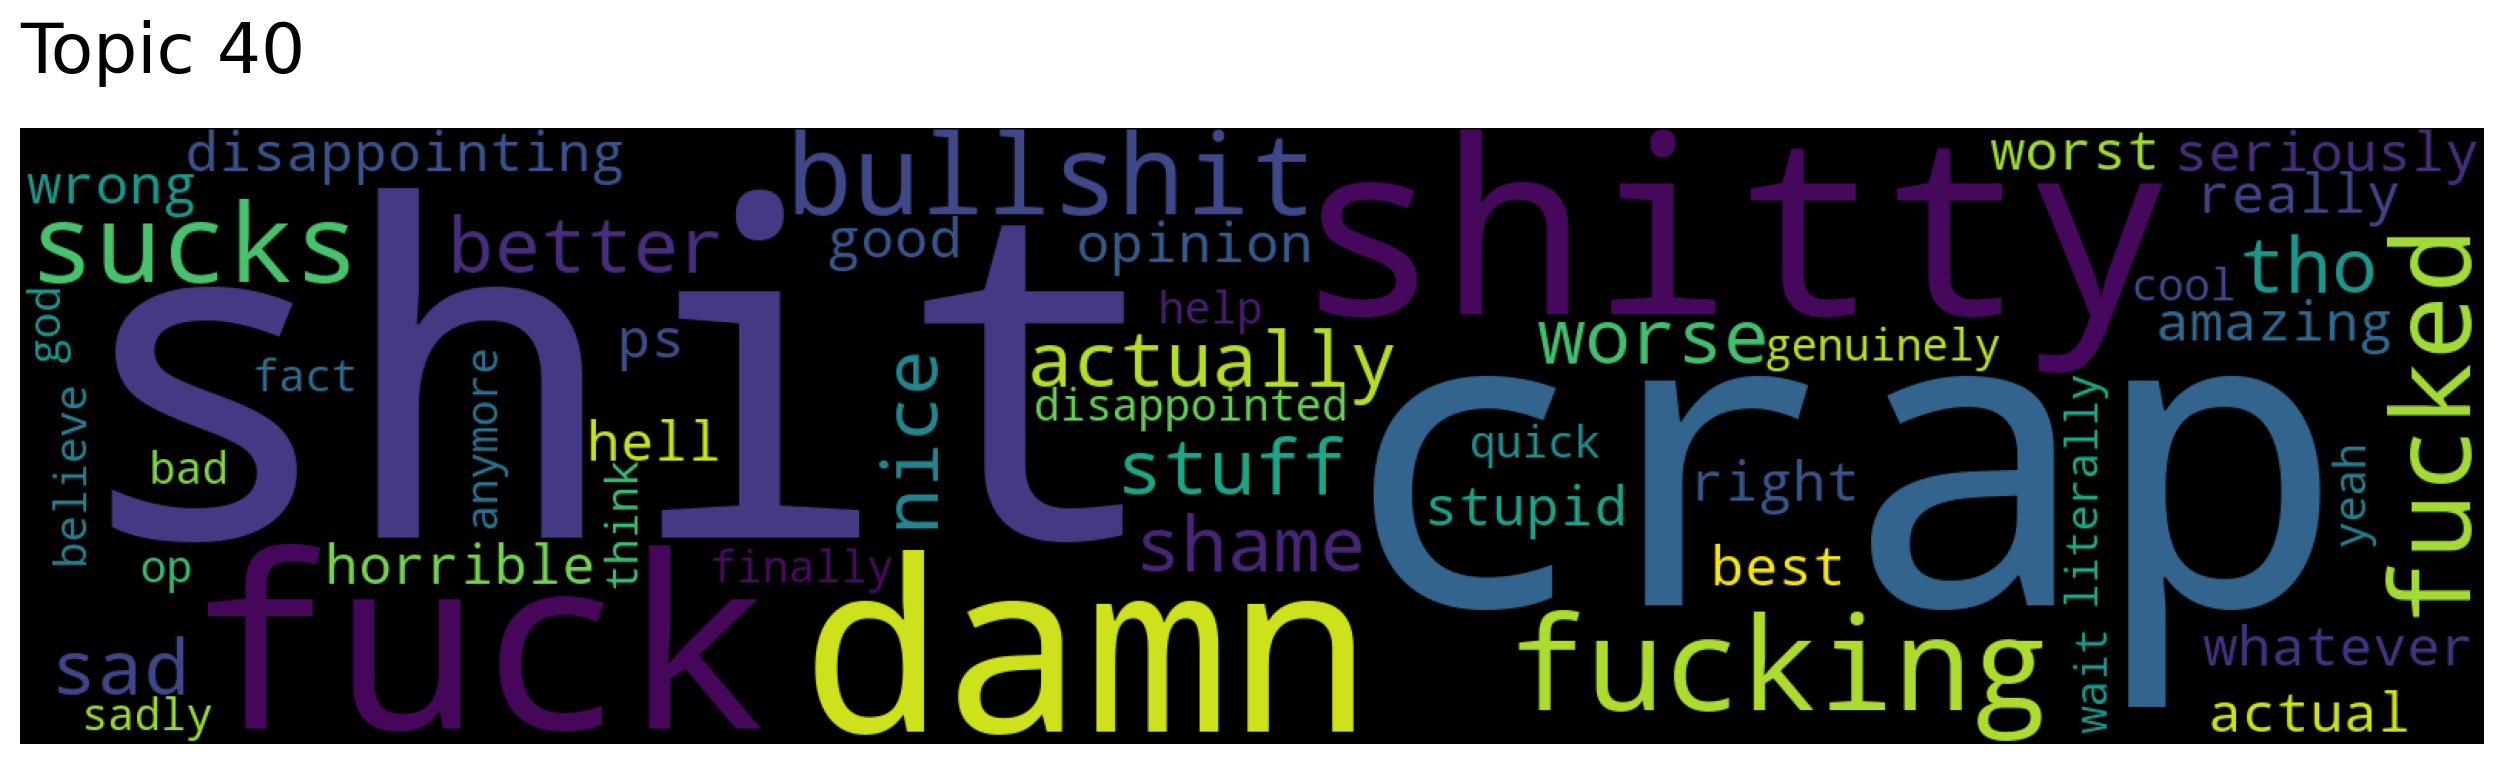

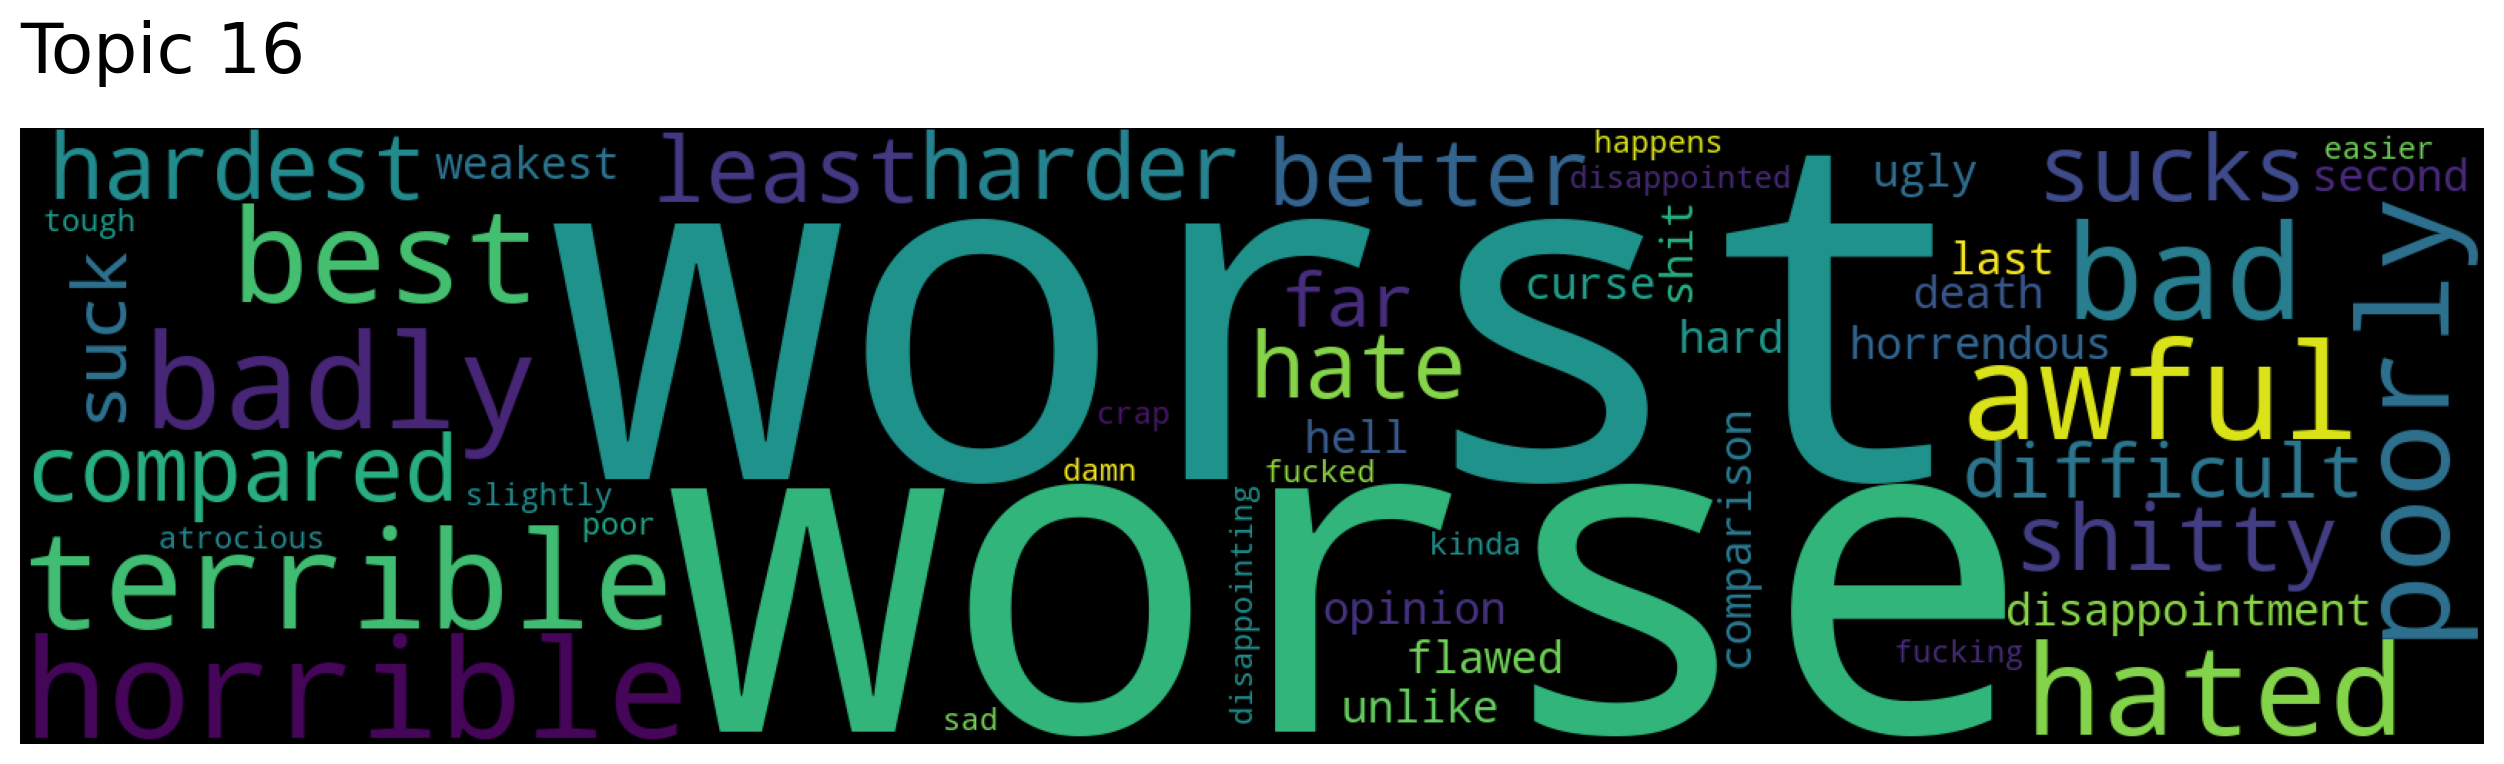

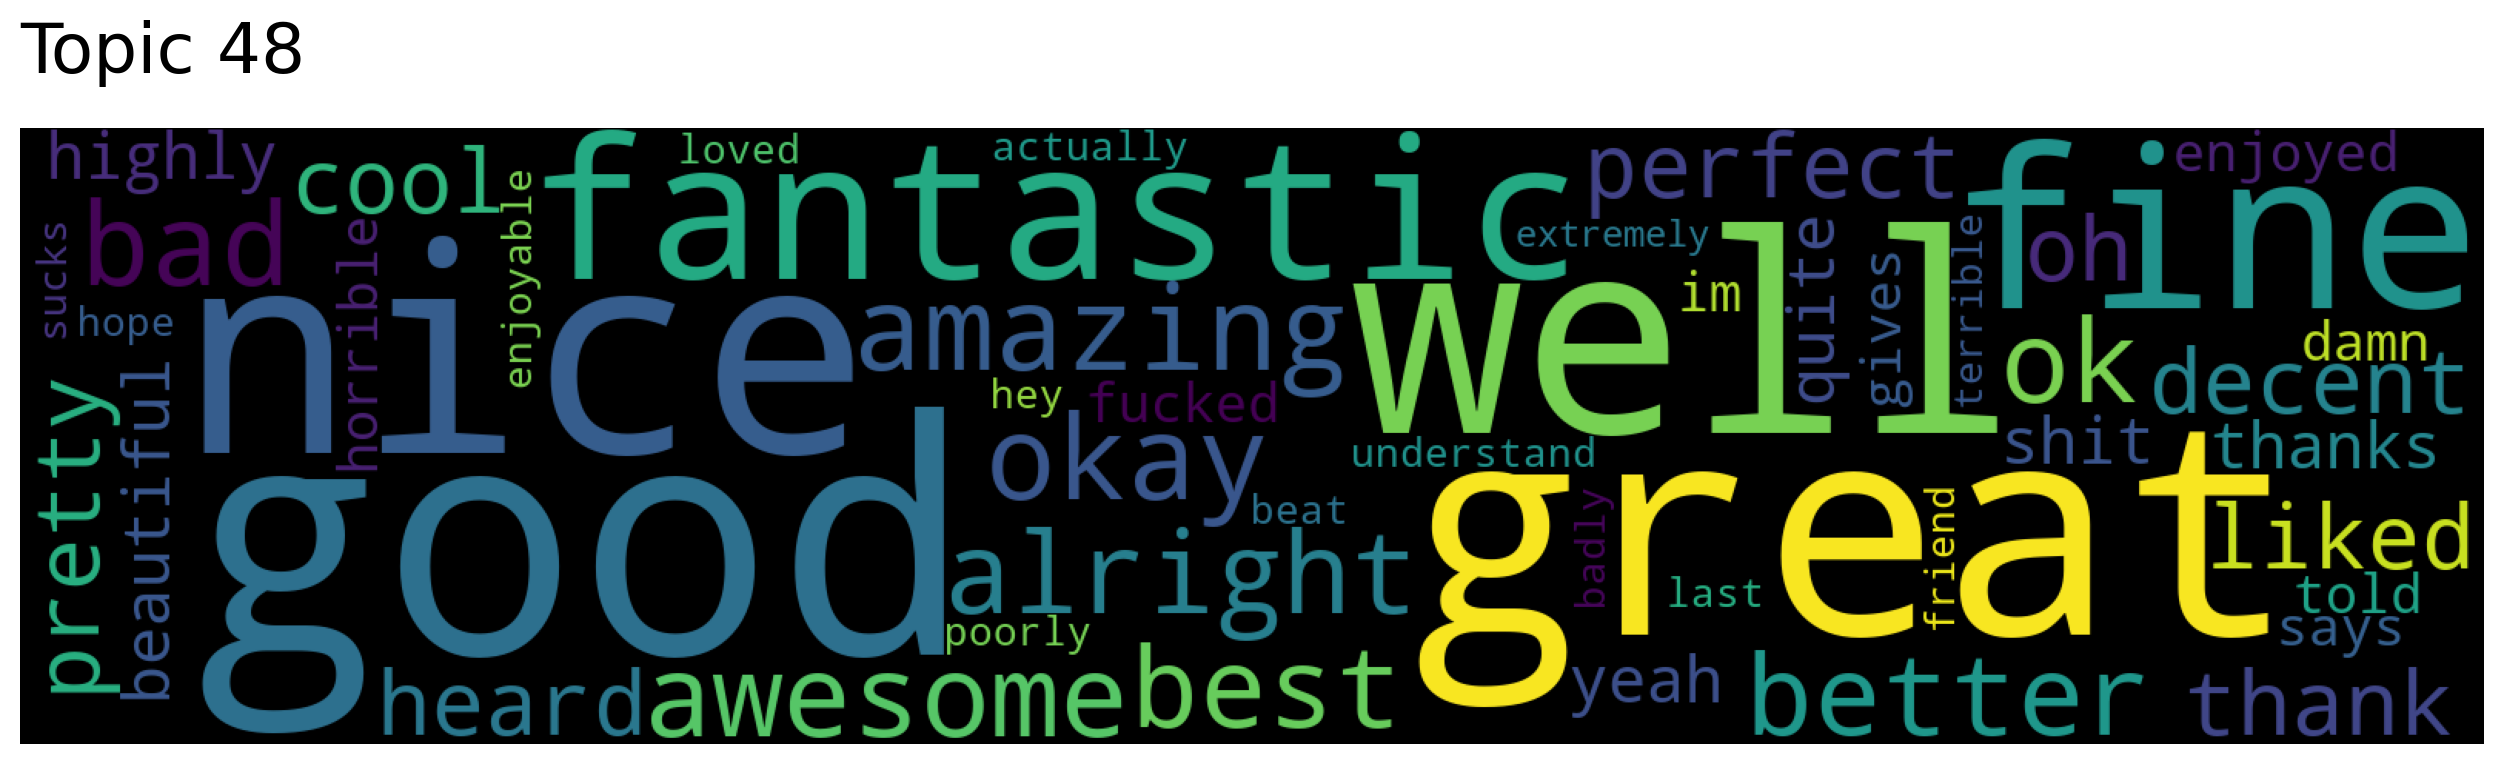

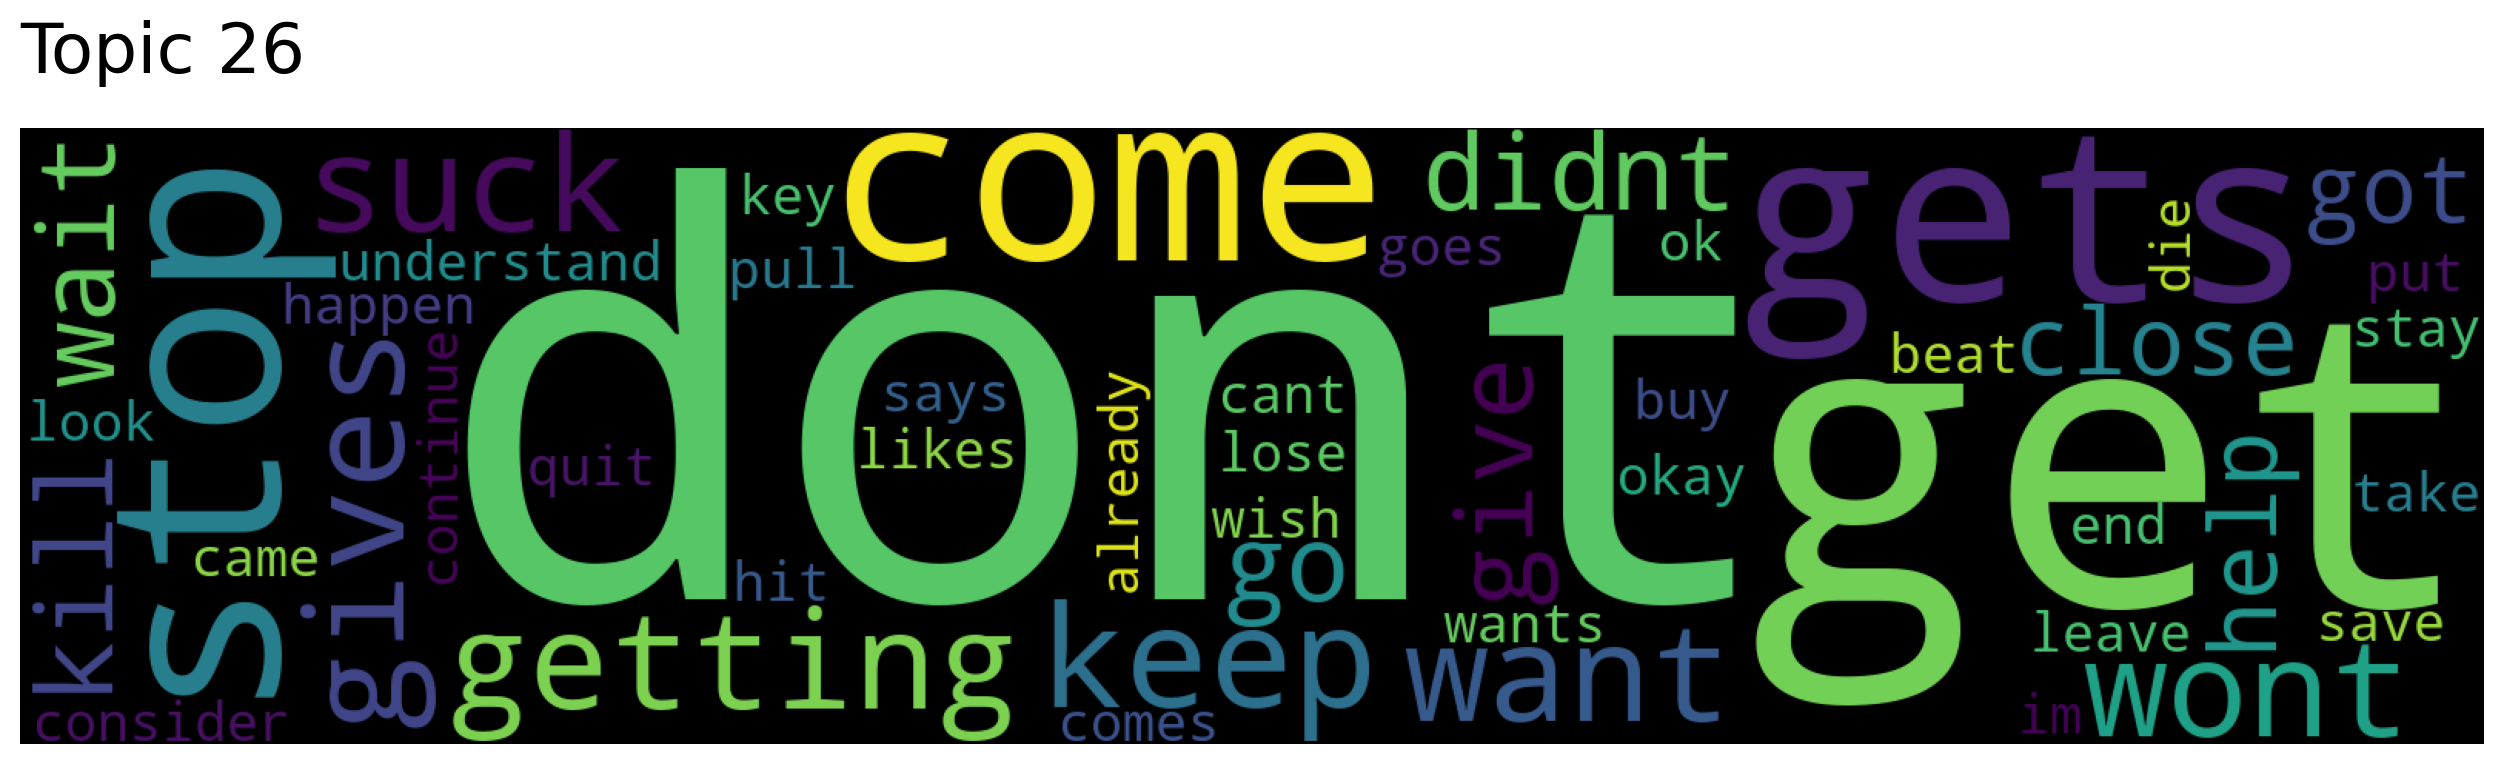

In [13]:
topic_words, word_scores, topic_scores, topic_nums = neg_mdl.search_topics(keywords=["story"], num_topics=5)
for topic in topic_nums:
    neg_mdl.generate_topic_wordcloud(topic)